In [150]:
import tensorflow as tf

# Enable eager execution explicitly (in case it's turned off)
tf.config.run_functions_eagerly(True)

print(f"Eager execution enabled: {tf.executing_eagerly()}")


Eager execution enabled: True


In [1]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, ReLU, BatchNormalization
from tensorflow.keras.models import Model
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def load_image(file_path):
    # Load and normalize image to [-1, 1]
    img = tf.io.read_file(file_path)  # Direct file path
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [256, 256])  # Resize to fixed size
    img = (tf.cast(img, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    return img

def load_data(path, batch_size=16):
    files = glob(os.path.join(path, "*.png"))
    print(f"Files found in {path}: {files}")  # Debugging: Check file paths
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_image).batch(batch_size).shuffle(buffer_size=1000)
    return dataset


# Paths
data_path = r"E:\ideas\music2\music2_spectrograms"
train_piano_path = os.path.join(data_path, "Train_submission", "Sound_Piano")
train_guitar_path = os.path.join(data_path, "Train_submission", "Sound_Guitar")

# Load datasets
piano_dataset = load_data(train_piano_path)
guitar_dataset = load_data(train_guitar_path)

Files found in E:\ideas\music2\music2_spectrograms\Train_submission\Sound_Piano: ['E:\\ideas\\music2\\music2_spectrograms\\Train_submission\\Sound_Piano\\029500_morning-rain-piano-65875.png', 'E:\\ideas\\music2\\music2_spectrograms\\Train_submission\\Sound_Piano\\035568_upright-piano-71570.png', 'E:\\ideas\\music2\\music2_spectrograms\\Train_submission\\Sound_Piano\\another-sadmosphere-108461.png', 'E:\\ideas\\music2\\music2_spectrograms\\Train_submission\\Sound_Piano\\arpeggio-01-36024.png', 'E:\\ideas\\music2\\music2_spectrograms\\Train_submission\\Sound_Piano\\beautiful-random-minor-arp-119378.png', 'E:\\ideas\\music2\\music2_spectrograms\\Train_submission\\Sound_Piano\\boogie-woogie-logo-116102.png', 'E:\\ideas\\music2\\music2_spectrograms\\Train_submission\\Sound_Piano\\c-aeol-12984.png', 'E:\\ideas\\music2\\music2_spectrograms\\Train_submission\\Sound_Piano\\cold-wednesday-73830.png', 'E:\\ideas\\music2\\music2_spectrograms\\Train_submission\\Sound_Piano\\converted_to_wav_file.pn

In [3]:
# Define CycleGAN Architecture
#Generator
def build_generator():
    inputs = Input(shape=[256, 256, 3])

    # Encoder
    x = Conv2D(64, (4, 4), strides=2, padding="same")(inputs)
    x = LeakyReLU()(x)
    x = Conv2D(128, (4, 4), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    # Bottleneck
    x = Conv2D(256, (4, 4), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    # Decoder
    x = Conv2DTranspose(128, (4, 4), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2DTranspose(64, (4, 4), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    outputs = Conv2DTranspose(3, (4, 4), strides=2, padding="same", activation="tanh")(x)
    return Model(inputs, outputs)

In [4]:
#Discriminator
def build_discriminator():
    inputs = Input(shape=[256, 256, 3])
    x = Conv2D(64, (4, 4), strides=2, padding="same")(inputs)
    x = LeakyReLU()(x)
    x = Conv2D(128, (4, 4), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(256, (4, 4), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(1, (4, 4), strides=1, padding="same")(x)
    return Model(inputs, x)

In [5]:
#Define Loss Functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, fake):
    real_loss = loss_obj(tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

def generator_loss(fake):
    return loss_obj(tf.ones_like(fake), fake)

def cycle_consistency_loss(real, cycled):
    return tf.reduce_mean(tf.abs(real - cycled))

def identity_loss(real, same):
    return tf.reduce_mean(tf.abs(real - same))

In [6]:
#Build and Compile the Model
# Initialize models
generator_piano_to_guitar = build_generator()
generator_guitar_to_piano = build_generator()
discriminator_piano = build_discriminator()
discriminator_guitar = build_discriminator()

# Optimizers
gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

previous training code

In [7]:
# Define training parameters
gen_optimizer_piano_to_guitar = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
gen_optimizer_guitar_to_piano = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer_piano = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer_guitar = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Train step function
@tf.function
def train_step(real_piano, real_guitar):
    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images
        fake_guitar = generator_piano_to_guitar(real_piano, training=True)
        fake_piano = generator_guitar_to_piano(real_guitar, training=True)

        # Cycle consistency
        cycled_piano = generator_guitar_to_piano(fake_guitar, training=True)
        cycled_guitar = generator_piano_to_guitar(fake_piano, training=True)

        # Identity mapping
        same_piano = generator_guitar_to_piano(real_piano, training=True)
        same_guitar = generator_piano_to_guitar(real_guitar, training=True)

        # Discriminator outputs
        disc_real_piano = discriminator_piano(real_piano, training=True)
        disc_fake_piano = discriminator_piano(fake_piano, training=True)

        disc_real_guitar = discriminator_guitar(real_guitar, training=True)
        disc_fake_guitar = discriminator_guitar(fake_guitar, training=True)

        # Losses
        gen_piano_to_guitar_loss = generator_loss(disc_fake_guitar) + cycle_consistency_loss(real_piano, cycled_piano) + identity_loss(real_piano, same_piano)
        gen_guitar_to_piano_loss = generator_loss(disc_fake_piano) + cycle_consistency_loss(real_guitar, cycled_guitar) + identity_loss(real_guitar, same_guitar)

        disc_piano_loss = discriminator_loss(disc_real_piano, disc_fake_piano)
        disc_guitar_loss = discriminator_loss(disc_real_guitar, disc_fake_guitar)

    # Compute and apply gradients for generators
    gen_piano_to_guitar_gradients = tape.gradient(gen_piano_to_guitar_loss, generator_piano_to_guitar.trainable_variables)
    gen_guitar_to_piano_gradients = tape.gradient(gen_guitar_to_piano_loss, generator_guitar_to_piano.trainable_variables)
    gen_optimizer_piano_to_guitar.apply_gradients(zip(gen_piano_to_guitar_gradients, generator_piano_to_guitar.trainable_variables))
    gen_optimizer_guitar_to_piano.apply_gradients(zip(gen_guitar_to_piano_gradients, generator_guitar_to_piano.trainable_variables))

    # Compute and apply gradients for discriminators
    disc_piano_gradients = tape.gradient(disc_piano_loss, discriminator_piano.trainable_variables)
    disc_guitar_gradients = tape.gradient(disc_guitar_loss, discriminator_guitar.trainable_variables)
    disc_optimizer_piano.apply_gradients(zip(disc_piano_gradients, discriminator_piano.trainable_variables))
    disc_optimizer_guitar.apply_gradients(zip(disc_guitar_gradients, discriminator_guitar.trainable_variables))

    del tape  # Free up memory

    return gen_piano_to_guitar_loss, gen_guitar_to_piano_loss, disc_piano_loss, disc_guitar_loss

# Test step function
@tf.function
def test_step(real_piano, real_guitar):
    fake_guitar = generator_piano_to_guitar(real_piano, training=False)
    fake_piano = generator_guitar_to_piano(real_guitar, training=False)

    cycled_piano = generator_guitar_to_piano(fake_guitar, training=False)
    cycled_guitar = generator_piano_to_guitar(fake_piano, training=False)

    return fake_guitar, fake_piano, cycled_piano, cycled_guitar

In [8]:
# Define constants
EPOCHS = 50

# Updated training loop
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    progress_bar = tqdm(total=len(piano_dataset), desc="Batch Progress", unit="batch")
    
    # Initialize accumulators for losses
    train_gen_loss_piano_to_guitar = 0
    train_gen_loss_guitar_to_piano = 0
    train_disc_loss_piano = 0
    train_disc_loss_guitar = 0

    # Training phase
    for real_piano, real_guitar in zip(piano_dataset, guitar_dataset):
        gen_loss_piano_to_guitar, gen_loss_guitar_to_piano, disc_loss_piano, disc_loss_guitar = train_step(real_piano, real_guitar)
        train_gen_loss_piano_to_guitar += gen_loss_piano_to_guitar
        train_gen_loss_guitar_to_piano += gen_loss_guitar_to_piano
        train_disc_loss_piano += disc_loss_piano
        train_disc_loss_guitar += disc_loss_guitar
        progress_bar.update(1)
    
    progress_bar.close()

    # Calculate average training losses
    num_batches = len(piano_dataset)
    avg_train_gen_loss_piano_to_guitar = train_gen_loss_piano_to_guitar / num_batches
    avg_train_gen_loss_guitar_to_piano = train_gen_loss_guitar_to_piano / num_batches
    avg_train_disc_loss_piano = train_disc_loss_piano / num_batches
    avg_train_disc_loss_guitar = train_disc_loss_guitar / num_batches

    # Log training results
    print(f"Training - Gen Loss (Piano->Guitar): {avg_train_gen_loss_piano_to_guitar:.4f}, "
          f"Gen Loss (Guitar->Piano): {avg_train_gen_loss_guitar_to_piano:.4f}, "
          f"Disc Loss (Piano): {avg_train_disc_loss_piano:.4f}, "
          f"Disc Loss (Guitar): {avg_train_disc_loss_guitar:.4f}")

    # Testing phase
    test_gen_loss_piano_to_guitar = 0
    test_gen_loss_guitar_to_piano = 0
    test_disc_loss_piano = 0
    test_disc_loss_guitar = 0
    total_correct = 0
    total_samples = 0

    for real_piano, real_guitar in zip(piano_dataset, guitar_dataset):
        fake_guitar, fake_piano, cycled_piano, cycled_guitar = test_step(real_piano, real_guitar)

        # Calculate testing losses
        test_gen_loss_piano_to_guitar += generator_loss(discriminator_guitar(fake_guitar, training=False))
        test_gen_loss_guitar_to_piano += generator_loss(discriminator_piano(fake_piano, training=False))
        test_disc_loss_piano += discriminator_loss(discriminator_piano(real_piano, training=False), discriminator_piano(fake_piano, training=False))
        test_disc_loss_guitar += discriminator_loss(discriminator_guitar(real_guitar, training=False), discriminator_guitar(fake_guitar, training=False))

        # Calculate accuracy (dummy metric: count how often fake outputs are classified correctly)
        total_correct += (tf.reduce_mean(fake_guitar).numpy() > 0.5).sum() + (tf.reduce_mean(fake_piano).numpy() > 0.5).sum()
        total_samples += real_piano.shape[0] + real_guitar.shape[0]

    # Calculate average testing losses and accuracy
    num_test_batches = len(piano_dataset)
    avg_test_gen_loss_piano_to_guitar = test_gen_loss_piano_to_guitar / num_test_batches
    avg_test_gen_loss_guitar_to_piano = test_gen_loss_guitar_to_piano / num_test_batches
    avg_test_disc_loss_piano = test_disc_loss_piano / num_test_batches
    avg_test_disc_loss_guitar = test_disc_loss_guitar / num_test_batches
    accuracy = (total_correct / total_samples) * 100

    # Log testing results
    print(f"Testing - Gen Loss (Piano->Guitar): {avg_test_gen_loss_piano_to_guitar:.4f}, "
          f"Gen Loss (Guitar->Piano): {avg_test_gen_loss_guitar_to_piano:.4f}, "
          f"Disc Loss (Piano): {avg_test_disc_loss_piano:.4f}, "
          f"Disc Loss (Guitar): {avg_test_disc_loss_guitar:.4f}, "
          f"Accuracy: {accuracy:.2f}%")

# Save models after all epochs
generator_piano_to_guitar.save("final_generator_piano_to_guitar.h5")
generator_guitar_to_piano.save("final_generator_guitar_to_piano.h5")
print("Final models saved.")



Epoch 1/50


Batch Progress: 100%|██████████| 33/33 [03:06<00:00,  5.66s/batch]


Training - Gen Loss (Piano->Guitar): 2.3484, Gen Loss (Guitar->Piano): 2.6133, Disc Loss (Piano): 0.5861, Disc Loss (Guitar): 0.6285
Testing - Gen Loss (Piano->Guitar): 0.7909, Gen Loss (Guitar->Piano): 0.8389, Disc Loss (Piano): 0.6406, Disc Loss (Guitar): 0.6815, Accuracy: 0.00%

Epoch 2/50


Batch Progress: 100%|██████████| 33/33 [02:59<00:00,  5.44s/batch]


Training - Gen Loss (Piano->Guitar): 2.0670, Gen Loss (Guitar->Piano): 2.3058, Disc Loss (Piano): 0.5655, Disc Loss (Guitar): 0.5907
Testing - Gen Loss (Piano->Guitar): 0.8721, Gen Loss (Guitar->Piano): 1.1021, Disc Loss (Piano): 0.6458, Disc Loss (Guitar): 0.7433, Accuracy: 0.00%

Epoch 3/50


Batch Progress: 100%|██████████| 33/33 [02:37<00:00,  4.79s/batch]


Training - Gen Loss (Piano->Guitar): 1.6078, Gen Loss (Guitar->Piano): 1.7583, Disc Loss (Piano): 0.6425, Disc Loss (Guitar): 0.6543
Testing - Gen Loss (Piano->Guitar): 1.0200, Gen Loss (Guitar->Piano): 1.0937, Disc Loss (Piano): 0.6729, Disc Loss (Guitar): 0.7713, Accuracy: 0.00%

Epoch 4/50


Batch Progress: 100%|██████████| 33/33 [02:36<00:00,  4.75s/batch]


Training - Gen Loss (Piano->Guitar): 1.4120, Gen Loss (Guitar->Piano): 1.4972, Disc Loss (Piano): 0.6773, Disc Loss (Guitar): 0.6699
Testing - Gen Loss (Piano->Guitar): 1.0995, Gen Loss (Guitar->Piano): 1.0053, Disc Loss (Piano): 0.6634, Disc Loss (Guitar): 0.7489, Accuracy: 0.00%

Epoch 5/50


Batch Progress: 100%|██████████| 33/33 [02:36<00:00,  4.75s/batch]


Training - Gen Loss (Piano->Guitar): 1.3407, Gen Loss (Guitar->Piano): 1.4208, Disc Loss (Piano): 0.6735, Disc Loss (Guitar): 0.6689
Testing - Gen Loss (Piano->Guitar): 1.1899, Gen Loss (Guitar->Piano): 1.0447, Disc Loss (Piano): 0.7095, Disc Loss (Guitar): 0.8103, Accuracy: 0.00%

Epoch 6/50


Batch Progress: 100%|██████████| 33/33 [02:37<00:00,  4.78s/batch]


Training - Gen Loss (Piano->Guitar): 1.3091, Gen Loss (Guitar->Piano): 1.3581, Disc Loss (Piano): 0.6726, Disc Loss (Guitar): 0.6681
Testing - Gen Loss (Piano->Guitar): 1.0693, Gen Loss (Guitar->Piano): 0.9754, Disc Loss (Piano): 0.7264, Disc Loss (Guitar): 0.7134, Accuracy: 0.00%

Epoch 7/50


Batch Progress: 100%|██████████| 33/33 [02:39<00:00,  4.83s/batch]


Training - Gen Loss (Piano->Guitar): 1.2836, Gen Loss (Guitar->Piano): 1.3411, Disc Loss (Piano): 0.6644, Disc Loss (Guitar): 0.6626
Testing - Gen Loss (Piano->Guitar): 0.8752, Gen Loss (Guitar->Piano): 0.9694, Disc Loss (Piano): 0.6966, Disc Loss (Guitar): 0.7106, Accuracy: 0.00%

Epoch 8/50


Batch Progress: 100%|██████████| 33/33 [02:39<00:00,  4.84s/batch]


Training - Gen Loss (Piano->Guitar): 1.2741, Gen Loss (Guitar->Piano): 1.3180, Disc Loss (Piano): 0.6488, Disc Loss (Guitar): 0.6563
Testing - Gen Loss (Piano->Guitar): 0.8389, Gen Loss (Guitar->Piano): 0.8870, Disc Loss (Piano): 0.6680, Disc Loss (Guitar): 0.6657, Accuracy: 0.00%

Epoch 9/50


Batch Progress: 100%|██████████| 33/33 [02:38<00:00,  4.82s/batch]


Training - Gen Loss (Piano->Guitar): 1.2687, Gen Loss (Guitar->Piano): 1.3429, Disc Loss (Piano): 0.6416, Disc Loss (Guitar): 0.6564
Testing - Gen Loss (Piano->Guitar): 1.0501, Gen Loss (Guitar->Piano): 0.8536, Disc Loss (Piano): 0.7287, Disc Loss (Guitar): 0.6679, Accuracy: 0.00%

Epoch 10/50


Batch Progress: 100%|██████████| 33/33 [02:39<00:00,  4.84s/batch]


Training - Gen Loss (Piano->Guitar): 1.2557, Gen Loss (Guitar->Piano): 1.3345, Disc Loss (Piano): 0.6342, Disc Loss (Guitar): 0.6545
Testing - Gen Loss (Piano->Guitar): 0.7668, Gen Loss (Guitar->Piano): 0.7307, Disc Loss (Piano): 0.6570, Disc Loss (Guitar): 0.6729, Accuracy: 0.00%

Epoch 11/50


Batch Progress: 100%|██████████| 33/33 [02:38<00:00,  4.81s/batch]


Training - Gen Loss (Piano->Guitar): 1.2417, Gen Loss (Guitar->Piano): 1.2947, Disc Loss (Piano): 0.6136, Disc Loss (Guitar): 0.6495
Testing - Gen Loss (Piano->Guitar): 0.7287, Gen Loss (Guitar->Piano): 0.7201, Disc Loss (Piano): 0.6921, Disc Loss (Guitar): 0.6646, Accuracy: 0.00%

Epoch 12/50


Batch Progress: 100%|██████████| 33/33 [02:38<00:00,  4.81s/batch]


Training - Gen Loss (Piano->Guitar): 1.2321, Gen Loss (Guitar->Piano): 1.3621, Disc Loss (Piano): 0.6049, Disc Loss (Guitar): 0.6523
Testing - Gen Loss (Piano->Guitar): 0.6837, Gen Loss (Guitar->Piano): 0.6463, Disc Loss (Piano): 0.7093, Disc Loss (Guitar): 0.6842, Accuracy: 0.00%

Epoch 13/50


Batch Progress: 100%|██████████| 33/33 [02:39<00:00,  4.84s/batch]


Training - Gen Loss (Piano->Guitar): 1.2423, Gen Loss (Guitar->Piano): 1.3839, Disc Loss (Piano): 0.5825, Disc Loss (Guitar): 0.6538
Testing - Gen Loss (Piano->Guitar): 0.5687, Gen Loss (Guitar->Piano): 0.6188, Disc Loss (Piano): 0.7383, Disc Loss (Guitar): 0.8217, Accuracy: 0.00%

Epoch 14/50


Batch Progress: 100%|██████████| 33/33 [02:40<00:00,  4.86s/batch]


Training - Gen Loss (Piano->Guitar): 1.2092, Gen Loss (Guitar->Piano): 1.3471, Disc Loss (Piano): 0.5923, Disc Loss (Guitar): 0.6464
Testing - Gen Loss (Piano->Guitar): 0.6030, Gen Loss (Guitar->Piano): 1.0366, Disc Loss (Piano): 0.7049, Disc Loss (Guitar): 0.7275, Accuracy: 0.00%

Epoch 15/50


Batch Progress: 100%|██████████| 33/33 [02:40<00:00,  4.85s/batch]


Training - Gen Loss (Piano->Guitar): 1.2069, Gen Loss (Guitar->Piano): 1.3110, Disc Loss (Piano): 0.6168, Disc Loss (Guitar): 0.6236
Testing - Gen Loss (Piano->Guitar): 0.9608, Gen Loss (Guitar->Piano): 1.2212, Disc Loss (Piano): 0.5389, Disc Loss (Guitar): 0.6997, Accuracy: 0.00%

Epoch 16/50


Batch Progress: 100%|██████████| 33/33 [02:39<00:00,  4.82s/batch]


Training - Gen Loss (Piano->Guitar): 1.2030, Gen Loss (Guitar->Piano): 1.2865, Disc Loss (Piano): 0.6085, Disc Loss (Guitar): 0.6385
Testing - Gen Loss (Piano->Guitar): 1.0563, Gen Loss (Guitar->Piano): 0.7104, Disc Loss (Piano): 0.6814, Disc Loss (Guitar): 0.6659, Accuracy: 0.00%

Epoch 17/50


Batch Progress: 100%|██████████| 33/33 [02:39<00:00,  4.84s/batch]


Training - Gen Loss (Piano->Guitar): 1.2492, Gen Loss (Guitar->Piano): 1.3041, Disc Loss (Piano): 0.5850, Disc Loss (Guitar): 0.6298
Testing - Gen Loss (Piano->Guitar): 1.2487, Gen Loss (Guitar->Piano): 1.2545, Disc Loss (Piano): 0.6223, Disc Loss (Guitar): 0.9683, Accuracy: 0.00%

Epoch 18/50


Batch Progress: 100%|██████████| 33/33 [02:39<00:00,  4.83s/batch]


Training - Gen Loss (Piano->Guitar): 1.2179, Gen Loss (Guitar->Piano): 1.3173, Disc Loss (Piano): 0.5836, Disc Loss (Guitar): 0.6214
Testing - Gen Loss (Piano->Guitar): 0.7622, Gen Loss (Guitar->Piano): 0.9455, Disc Loss (Piano): 0.6679, Disc Loss (Guitar): 0.6163, Accuracy: 0.00%

Epoch 19/50


Batch Progress: 100%|██████████| 33/33 [02:40<00:00,  4.87s/batch]


Training - Gen Loss (Piano->Guitar): 1.2200, Gen Loss (Guitar->Piano): 1.3643, Disc Loss (Piano): 0.5968, Disc Loss (Guitar): 0.6215
Testing - Gen Loss (Piano->Guitar): 0.8089, Gen Loss (Guitar->Piano): 0.9262, Disc Loss (Piano): 0.6902, Disc Loss (Guitar): 0.6868, Accuracy: 0.00%

Epoch 20/50


Batch Progress: 100%|██████████| 33/33 [02:40<00:00,  4.87s/batch]


Training - Gen Loss (Piano->Guitar): 1.2044, Gen Loss (Guitar->Piano): 1.3259, Disc Loss (Piano): 0.5851, Disc Loss (Guitar): 0.6136
Testing - Gen Loss (Piano->Guitar): 0.8143, Gen Loss (Guitar->Piano): 1.1047, Disc Loss (Piano): 0.6264, Disc Loss (Guitar): 0.5990, Accuracy: 0.00%

Epoch 21/50


Batch Progress: 100%|██████████| 33/33 [02:40<00:00,  4.85s/batch]


Training - Gen Loss (Piano->Guitar): 1.1775, Gen Loss (Guitar->Piano): 1.2527, Disc Loss (Piano): 0.6023, Disc Loss (Guitar): 0.6192
Testing - Gen Loss (Piano->Guitar): 1.0410, Gen Loss (Guitar->Piano): 0.9499, Disc Loss (Piano): 0.5780, Disc Loss (Guitar): 0.6577, Accuracy: 0.00%

Epoch 22/50


Batch Progress: 100%|██████████| 33/33 [02:41<00:00,  4.88s/batch]


Training - Gen Loss (Piano->Guitar): 1.1902, Gen Loss (Guitar->Piano): 1.2492, Disc Loss (Piano): 0.6112, Disc Loss (Guitar): 0.6086
Testing - Gen Loss (Piano->Guitar): 0.9862, Gen Loss (Guitar->Piano): 1.1954, Disc Loss (Piano): 0.7249, Disc Loss (Guitar): 0.6288, Accuracy: 0.00%

Epoch 23/50


Batch Progress: 100%|██████████| 33/33 [02:40<00:00,  4.87s/batch]


Training - Gen Loss (Piano->Guitar): 1.1865, Gen Loss (Guitar->Piano): 1.2172, Disc Loss (Piano): 0.6222, Disc Loss (Guitar): 0.6460
Testing - Gen Loss (Piano->Guitar): 0.8396, Gen Loss (Guitar->Piano): 0.8035, Disc Loss (Piano): 0.5783, Disc Loss (Guitar): 0.6566, Accuracy: 0.00%

Epoch 24/50


Batch Progress: 100%|██████████| 33/33 [02:40<00:00,  4.86s/batch]


Training - Gen Loss (Piano->Guitar): 1.1454, Gen Loss (Guitar->Piano): 1.2392, Disc Loss (Piano): 0.6007, Disc Loss (Guitar): 0.6269
Testing - Gen Loss (Piano->Guitar): 1.0474, Gen Loss (Guitar->Piano): 0.7841, Disc Loss (Piano): 0.7905, Disc Loss (Guitar): 0.6049, Accuracy: 0.00%

Epoch 25/50


Batch Progress: 100%|██████████| 33/33 [02:40<00:00,  4.87s/batch]


Training - Gen Loss (Piano->Guitar): 1.1720, Gen Loss (Guitar->Piano): 1.2238, Disc Loss (Piano): 0.6535, Disc Loss (Guitar): 0.6189
Testing - Gen Loss (Piano->Guitar): 1.0279, Gen Loss (Guitar->Piano): 0.7512, Disc Loss (Piano): 0.6145, Disc Loss (Guitar): 0.6506, Accuracy: 0.00%

Epoch 26/50


Batch Progress: 100%|██████████| 33/33 [02:40<00:00,  4.86s/batch]


Training - Gen Loss (Piano->Guitar): 1.1709, Gen Loss (Guitar->Piano): 1.1828, Disc Loss (Piano): 0.5983, Disc Loss (Guitar): 0.6153
Testing - Gen Loss (Piano->Guitar): 0.6568, Gen Loss (Guitar->Piano): 0.6773, Disc Loss (Piano): 0.7056, Disc Loss (Guitar): 0.6790, Accuracy: 0.00%

Epoch 27/50


Batch Progress: 100%|██████████| 33/33 [02:42<00:00,  4.92s/batch]


Training - Gen Loss (Piano->Guitar): 1.1784, Gen Loss (Guitar->Piano): 1.2534, Disc Loss (Piano): 0.6000, Disc Loss (Guitar): 0.6275
Testing - Gen Loss (Piano->Guitar): 0.8617, Gen Loss (Guitar->Piano): 0.8786, Disc Loss (Piano): 0.6083, Disc Loss (Guitar): 0.6440, Accuracy: 0.00%

Epoch 28/50


Batch Progress: 100%|██████████| 33/33 [02:40<00:00,  4.88s/batch]


Training - Gen Loss (Piano->Guitar): 1.2051, Gen Loss (Guitar->Piano): 1.2639, Disc Loss (Piano): 0.5766, Disc Loss (Guitar): 0.6434
Testing - Gen Loss (Piano->Guitar): 0.9039, Gen Loss (Guitar->Piano): 1.2043, Disc Loss (Piano): 0.6969, Disc Loss (Guitar): 0.6572, Accuracy: 0.00%

Epoch 29/50


Batch Progress: 100%|██████████| 33/33 [02:41<00:00,  4.90s/batch]


Training - Gen Loss (Piano->Guitar): 1.1846, Gen Loss (Guitar->Piano): 1.2244, Disc Loss (Piano): 0.6021, Disc Loss (Guitar): 0.5866
Testing - Gen Loss (Piano->Guitar): 0.8478, Gen Loss (Guitar->Piano): 0.8219, Disc Loss (Piano): 0.6276, Disc Loss (Guitar): 0.6333, Accuracy: 0.00%

Epoch 30/50


Batch Progress: 100%|██████████| 33/33 [02:43<00:00,  4.96s/batch]


Training - Gen Loss (Piano->Guitar): 1.1686, Gen Loss (Guitar->Piano): 1.2329, Disc Loss (Piano): 0.5817, Disc Loss (Guitar): 0.6013
Testing - Gen Loss (Piano->Guitar): 0.8732, Gen Loss (Guitar->Piano): 1.1156, Disc Loss (Piano): 0.6546, Disc Loss (Guitar): 0.7064, Accuracy: 0.00%

Epoch 31/50


Batch Progress: 100%|██████████| 33/33 [02:40<00:00,  4.87s/batch]


Training - Gen Loss (Piano->Guitar): 1.2214, Gen Loss (Guitar->Piano): 1.2753, Disc Loss (Piano): 0.5801, Disc Loss (Guitar): 0.5988
Testing - Gen Loss (Piano->Guitar): 1.0089, Gen Loss (Guitar->Piano): 0.8897, Disc Loss (Piano): 0.6124, Disc Loss (Guitar): 0.5782, Accuracy: 0.00%

Epoch 32/50


Batch Progress: 100%|██████████| 33/33 [02:40<00:00,  4.88s/batch]


Training - Gen Loss (Piano->Guitar): 1.2471, Gen Loss (Guitar->Piano): 1.2694, Disc Loss (Piano): 0.5682, Disc Loss (Guitar): 0.5610
Testing - Gen Loss (Piano->Guitar): 0.7555, Gen Loss (Guitar->Piano): 0.8202, Disc Loss (Piano): 0.6659, Disc Loss (Guitar): 0.7411, Accuracy: 0.00%

Epoch 33/50


Batch Progress: 100%|██████████| 33/33 [04:10<00:00,  7.59s/batch]


Training - Gen Loss (Piano->Guitar): 1.2304, Gen Loss (Guitar->Piano): 1.3455, Disc Loss (Piano): 0.5631, Disc Loss (Guitar): 0.5707
Testing - Gen Loss (Piano->Guitar): 1.0287, Gen Loss (Guitar->Piano): 0.6245, Disc Loss (Piano): 0.9838, Disc Loss (Guitar): 0.5825, Accuracy: 0.00%

Epoch 34/50


Batch Progress: 100%|██████████| 33/33 [05:30<00:00, 10.02s/batch]


Training - Gen Loss (Piano->Guitar): 1.2857, Gen Loss (Guitar->Piano): 1.2688, Disc Loss (Piano): 0.5520, Disc Loss (Guitar): 0.5554
Testing - Gen Loss (Piano->Guitar): 0.9270, Gen Loss (Guitar->Piano): 0.7976, Disc Loss (Piano): 0.6382, Disc Loss (Guitar): 0.6431, Accuracy: 0.00%

Epoch 35/50


Batch Progress: 100%|██████████| 33/33 [04:25<00:00,  8.04s/batch]


Training - Gen Loss (Piano->Guitar): 1.3611, Gen Loss (Guitar->Piano): 1.3476, Disc Loss (Piano): 0.5246, Disc Loss (Guitar): 0.5255
Testing - Gen Loss (Piano->Guitar): 0.7102, Gen Loss (Guitar->Piano): 0.7526, Disc Loss (Piano): 0.6692, Disc Loss (Guitar): 0.7296, Accuracy: 0.00%

Epoch 36/50


Batch Progress: 100%|██████████| 33/33 [06:26<00:00, 11.71s/batch]


Training - Gen Loss (Piano->Guitar): 1.3621, Gen Loss (Guitar->Piano): 1.3960, Disc Loss (Piano): 0.5698, Disc Loss (Guitar): 0.5207
Testing - Gen Loss (Piano->Guitar): 0.9650, Gen Loss (Guitar->Piano): 1.7177, Disc Loss (Piano): 1.2830, Disc Loss (Guitar): 0.6126, Accuracy: 0.00%

Epoch 37/50


Batch Progress: 100%|██████████| 33/33 [02:51<00:00,  5.18s/batch]


Training - Gen Loss (Piano->Guitar): 1.4943, Gen Loss (Guitar->Piano): 1.3848, Disc Loss (Piano): 0.7431, Disc Loss (Guitar): 0.5344
Testing - Gen Loss (Piano->Guitar): 1.6271, Gen Loss (Guitar->Piano): 0.7292, Disc Loss (Piano): 0.6331, Disc Loss (Guitar): 1.3040, Accuracy: 0.00%

Epoch 38/50


Batch Progress: 100%|██████████| 33/33 [02:56<00:00,  5.34s/batch]


Training - Gen Loss (Piano->Guitar): 1.4600, Gen Loss (Guitar->Piano): 1.2661, Disc Loss (Piano): 0.5455, Disc Loss (Guitar): 0.5522
Testing - Gen Loss (Piano->Guitar): 0.9547, Gen Loss (Guitar->Piano): 0.9395, Disc Loss (Piano): 0.6422, Disc Loss (Guitar): 0.6089, Accuracy: 0.00%

Epoch 39/50


Batch Progress: 100%|██████████| 33/33 [02:50<00:00,  5.15s/batch]


Training - Gen Loss (Piano->Guitar): 1.3980, Gen Loss (Guitar->Piano): 1.2626, Disc Loss (Piano): 0.5318, Disc Loss (Guitar): 0.4870
Testing - Gen Loss (Piano->Guitar): 0.9282, Gen Loss (Guitar->Piano): 0.9353, Disc Loss (Piano): 0.6551, Disc Loss (Guitar): 0.5597, Accuracy: 0.00%

Epoch 40/50


Batch Progress: 100%|██████████| 33/33 [02:49<00:00,  5.14s/batch]


Training - Gen Loss (Piano->Guitar): 1.4297, Gen Loss (Guitar->Piano): 1.3477, Disc Loss (Piano): 0.5045, Disc Loss (Guitar): 0.4999
Testing - Gen Loss (Piano->Guitar): 0.9433, Gen Loss (Guitar->Piano): 0.7784, Disc Loss (Piano): 0.6484, Disc Loss (Guitar): 0.6544, Accuracy: 0.00%

Epoch 41/50


Batch Progress: 100%|██████████| 33/33 [02:48<00:00,  5.10s/batch]


Training - Gen Loss (Piano->Guitar): 1.4380, Gen Loss (Guitar->Piano): 1.3774, Disc Loss (Piano): 0.5031, Disc Loss (Guitar): 0.4811
Testing - Gen Loss (Piano->Guitar): 0.9109, Gen Loss (Guitar->Piano): 0.6302, Disc Loss (Piano): 0.6937, Disc Loss (Guitar): 0.7039, Accuracy: 0.00%

Epoch 42/50


Batch Progress: 100%|██████████| 33/33 [02:49<00:00,  5.14s/batch]


Training - Gen Loss (Piano->Guitar): 1.5091, Gen Loss (Guitar->Piano): 1.4434, Disc Loss (Piano): 0.4915, Disc Loss (Guitar): 0.4659
Testing - Gen Loss (Piano->Guitar): 1.0985, Gen Loss (Guitar->Piano): 0.9495, Disc Loss (Piano): 0.6812, Disc Loss (Guitar): 0.7237, Accuracy: 0.00%

Epoch 43/50


Batch Progress: 100%|██████████| 33/33 [02:49<00:00,  5.13s/batch]


Training - Gen Loss (Piano->Guitar): 1.5333, Gen Loss (Guitar->Piano): 1.5304, Disc Loss (Piano): 0.5985, Disc Loss (Guitar): 0.4785
Testing - Gen Loss (Piano->Guitar): 0.8938, Gen Loss (Guitar->Piano): 1.0642, Disc Loss (Piano): 0.6539, Disc Loss (Guitar): 0.6470, Accuracy: 0.00%

Epoch 44/50


Batch Progress: 100%|██████████| 33/33 [02:50<00:00,  5.17s/batch]


Training - Gen Loss (Piano->Guitar): 1.4867, Gen Loss (Guitar->Piano): 1.4169, Disc Loss (Piano): 0.4629, Disc Loss (Guitar): 0.4421
Testing - Gen Loss (Piano->Guitar): 0.7956, Gen Loss (Guitar->Piano): 1.0890, Disc Loss (Piano): 0.7192, Disc Loss (Guitar): 0.6321, Accuracy: 0.00%

Epoch 45/50


Batch Progress: 100%|██████████| 33/33 [02:48<00:00,  5.12s/batch]


Training - Gen Loss (Piano->Guitar): 1.5736, Gen Loss (Guitar->Piano): 1.4161, Disc Loss (Piano): 0.4738, Disc Loss (Guitar): 0.4938
Testing - Gen Loss (Piano->Guitar): 1.1612, Gen Loss (Guitar->Piano): 0.7817, Disc Loss (Piano): 0.6837, Disc Loss (Guitar): 0.5707, Accuracy: 0.00%

Epoch 46/50


Batch Progress: 100%|██████████| 33/33 [02:48<00:00,  5.10s/batch]


Training - Gen Loss (Piano->Guitar): 1.6140, Gen Loss (Guitar->Piano): 1.5567, Disc Loss (Piano): 0.4573, Disc Loss (Guitar): 0.4125
Testing - Gen Loss (Piano->Guitar): 0.8590, Gen Loss (Guitar->Piano): 1.5030, Disc Loss (Piano): 0.8060, Disc Loss (Guitar): 0.5953, Accuracy: 0.00%

Epoch 47/50


Batch Progress: 100%|██████████| 33/33 [02:49<00:00,  5.13s/batch]


Training - Gen Loss (Piano->Guitar): 1.5381, Gen Loss (Guitar->Piano): 1.5782, Disc Loss (Piano): 0.4302, Disc Loss (Guitar): 0.4335
Testing - Gen Loss (Piano->Guitar): 0.8116, Gen Loss (Guitar->Piano): 1.1686, Disc Loss (Piano): 0.6780, Disc Loss (Guitar): 0.6296, Accuracy: 0.00%

Epoch 48/50


Batch Progress: 100%|██████████| 33/33 [02:48<00:00,  5.11s/batch]


Training - Gen Loss (Piano->Guitar): 1.9376, Gen Loss (Guitar->Piano): 1.7196, Disc Loss (Piano): 0.4203, Disc Loss (Guitar): 0.6225
Testing - Gen Loss (Piano->Guitar): 0.8868, Gen Loss (Guitar->Piano): 1.0520, Disc Loss (Piano): 0.6977, Disc Loss (Guitar): 0.8347, Accuracy: 0.00%

Epoch 49/50


Batch Progress: 100%|██████████| 33/33 [02:49<00:00,  5.14s/batch]


Training - Gen Loss (Piano->Guitar): 1.5191, Gen Loss (Guitar->Piano): 1.5797, Disc Loss (Piano): 0.4625, Disc Loss (Guitar): 0.4551
Testing - Gen Loss (Piano->Guitar): 0.7904, Gen Loss (Guitar->Piano): 1.7778, Disc Loss (Piano): 1.0579, Disc Loss (Guitar): 0.6038, Accuracy: 0.00%

Epoch 50/50


Batch Progress: 100%|██████████| 33/33 [03:02<00:00,  5.52s/batch]


Training - Gen Loss (Piano->Guitar): 1.5005, Gen Loss (Guitar->Piano): 1.4089, Disc Loss (Piano): 0.5352, Disc Loss (Guitar): 0.4121


Testing - Gen Loss (Piano->Guitar): 0.7465, Gen Loss (Guitar->Piano): 1.2473, Disc Loss (Piano): 0.6707, Disc Loss (Guitar): 0.5844, Accuracy: 0.00%


Final models saved.


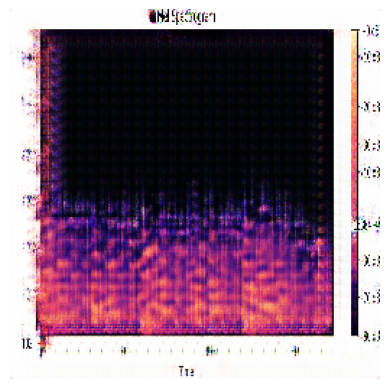

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image
import os

# Function to load and preprocess the image
def load_and_preprocess_image(file_path):
    # Check the file extension
    file_extension = os.path.splitext(file_path)[-1].lower()

    # Load the image depending on the file extension
    img = tf.io.read_file(file_path)
    
    if file_extension == '.png':
        img = tf.image.decode_png(img, channels=3)
    elif file_extension in ['.jpg', '.jpeg']:
        img = tf.image.decode_jpeg(img, channels=3)
    else:
        raise ValueError(f"Unsupported file extension: {file_extension}")

    img = tf.image.resize(img, [256, 256])  # Resize to match input size of the model
    img = (tf.cast(img, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    return img

# Function to predict using the trained CycleGAN model
def predict_image(input_image_path, generator_model, output_image_path=None):
    # Load and preprocess the image
    input_image = load_and_preprocess_image(input_image_path)
    input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension
    
    # Predict the translated image
    translated_image = generator_model(input_image, training=False)
    
    # Post-process the output image (denormalize to [0, 255])
    translated_image = (translated_image + 1) * 127.5
    translated_image = np.clip(translated_image, 0, 255).astype(np.uint8)

    # Convert the result to a PIL image for saving/displaying
    translated_img_pil = Image.fromarray(translated_image[0])

    # Save the image if an output path is provided
    if output_image_path:
        translated_img_pil.save(output_image_path)
    
    # Display the image
    plt.imshow(translated_image[0])
    plt.axis('off')  # Hide axes
    plt.show()

# Load the trained models (correct paths for each generator)
generator_piano_to_guitar = load_model(r"E:\ideas\music2 - Copy_org\models\final_generator_piano_to_guitar.h5")
generator_guitar_to_piano = load_model(r"E:\ideas\music2 - Copy_org\models\final_generator_guitar_to_piano.h5")

# Example usage
input_image_path = r"E:\ideas\music2 - Copy_org\music2_spectrograms\Test_submission\Sound_Piano\yuwu-quiz-113046.png" # Replace with the path to your input image
output_image_path = r"E:\ideas\yuwu-quiz-113046_output.png"  # Path to save the translated image (optional)

# Use the generator to translate a piano image to a guitar image
# predict_image(input_image_path, generator_piano_to_guitar, output_image_path)

# Use the generator to translate a guitar image to a piano image
predict_image(input_image_path, generator_guitar_to_piano, output_image_path)


In [33]:
import librosa
import numpy as np
from PIL import Image
import soundfile as sf

def spectrogram_to_audio(spectrogram_path, output_audio_path, sr=22050, n_fft=1024, hop_length=256):
    # Load the spectrogram image
    spectrogram_image = Image.open(spectrogram_path).convert("L")  # Convert to grayscale
    spectrogram = np.array(spectrogram_image) / 255.0  # Normalize to [0, 1]

    # Resize the spectrogram to match the expected dimensions (n_fft // 2 + 1, frames)
    expected_shape = (n_fft // 2 + 1, spectrogram.shape[1])  # Keep width as frames
    spectrogram = np.resize(spectrogram, expected_shape)

    # Convert back to the time-domain signal using Griffin-Lim
    audio = librosa.griffinlim(spectrogram, n_fft=n_fft, hop_length=hop_length)

    # Save the reconstructed audio
    sf.write(output_audio_path, audio, sr)

# Example usage
generated_spectrogram_path = r"E:\ideas\output4_image.png" 
output_audio_path = r"E:\ideas\output4.wav"

spectrogram_to_audio(generated_spectrogram_path, output_audio_path)
